# Project: Removing rain from images

In [ ]:
# 1. Setup: Clone CUT repo & install dependencies
!git clone https://github.com/taesungp/contrastive-unpaired-translation CUT
%cd CUT

!pip install -r requirements.txt
!pip install pytorch-fid
!pip install visdom dominate GPUtil
!pip install icrawler

import os
import random
import shutil
from PIL import Image, ImageDraw, ImageFilter
import numpy as np
from icrawler.builtin import GoogleImageCrawler

## Chuẩn bị Dataset
- Sử dụng bộ dataset sau cho cả huấn luyện và đánh giá: https://drive.google.com/drive/folders/1PUXDTdf0vGeZaH7sbc9xXCCTWM7ouwZ_
- Project hiện tại đang lấy dữ liệu bất kì từ trên mạng và thêm hiệu ứng mưa vào, điều này dẫn tới việc dữ liệu có thể không chính xác, ảnh hưởng tới khả năng của mô hình trong thực tế
- Mục tiêu của phần này: tìm kiếm hoặc sử dụng dữ liệu trên drive để huấn luyện, đánh giá mô hình. Viết code python để thay đổi dữ liệu cũ với dữ liệu mới

In [ ]:
def add_rain_effect(img, intensity=0.5):
    """Add synthetic rain effect to an image with random variations"""
    # Convert to RGBA if needed
    if img.mode != 'RGBA':
        img = img.convert('RGBA')
    
    width, height = img.size
    rain_layer = Image.new('RGBA', (width, height), (0, 0, 0, 0))
    draw = ImageDraw.Draw(rain_layer)
    
    # Random parameters for rain variation
    num_drops = int(intensity * width * height / 50)
    max_length = random.randint(5, 15)
    max_angle = random.randint(60, 80)
    opacity = random.randint(100, 200)
    
    # Draw rain streaks
    for _ in range(num_drops):
        x1 = random.randint(0, width)
        y1 = random.randint(0, height)
        angle = random.uniform(max_angle-10, max_angle+10)
        length = random.randint(3, max_length)
        x2 = x1 + length * np.cos(np.radians(angle))
        y2 = y1 + length * np.sin(np.radians(angle))
        draw.line([(x1, y1), (x2, y2)], fill=(200, 200, 255, opacity), width=1)
    
    # Add blur and water splash effect
    rain_layer = rain_layer.filter(ImageFilter.GaussianBlur(radius=1))
    
    # Composite with original image
    final_img = Image.alpha_composite(img, rain_layer)
    
    # Add overall darkening effect
    final_img = Image.blend(
        final_img, 
        Image.new('RGBA', (width, height), (50, 50, 70, 0)), 
        alpha=0.1 * intensity
    )
    
    return final_img.convert('RGB')

def create_rainy_dataset(dataset_dir, query, num_images=400, train_split=0.9, resize_shape=(256, 256)):
    """
    Create a rainy version of city street images dataset.
    
    Args:
        dataset_dir (str): Output dataset directory
        query (str): Search query for sunny city images
        num_images (int): Number of images to download
        train_split (float): Train/test split ratio
        resize_shape (tuple): Output image size
    """
    temp_dir = os.path.join(dataset_dir, "raw_sunny")
    os.makedirs(temp_dir, exist_ok=True)
    
    # Download sunny images
    print(f"📥 Downloading sunny images for: {query}")
    crawler = GoogleImageCrawler(storage={'root_dir': temp_dir})
    crawler.crawl(keyword=query, max_num=num_images)
    
    # Create output directories
    for folder in ['trainA', 'trainB', 'testA', 'testB']:
        os.makedirs(os.path.join(dataset_dir, folder), exist_ok=True)
    
    # Process images
    processed_count = 0
    for filename in os.listdir(temp_dir):
        if not filename.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        try:
            # Process sunny image (A)
            sunny_path = os.path.join(temp_dir, filename)
            with Image.open(sunny_path) as img:
                img = img.convert("RGB")
                img = img.resize(resize_shape, Image.Resampling.LANCZOS)
                
                # Create rainy version (B)
                rain_intensity = random.uniform(0.4, 0.8)  # Vary intensity
                rainy_img = add_rain_effect(img.copy(), intensity=rain_intensity)
                
                # Determine train/test split
                is_train = random.random() < train_split
                split = 'train' if is_train else 'test'
                
                # Save both versions
                sunny_img_path = os.path.join(dataset_dir, f"{split}A", filename)
                rainy_img_path = os.path.join(dataset_dir, f"{split}B", filename)
                
                img.save(sunny_img_path)
                rainy_img.save(rainy_img_path)
                
                processed_count += 1
                if processed_count % 50 == 0:
                    print(f"✅ Processed {processed_count} image pairs")
                    
        except Exception as e:
            print(f"⚠️ Error processing {filename}: {e}")
    
    shutil.rmtree(temp_dir)
    print(f"\n🎉 Dataset created at: {dataset_dir}")
    print(f"Sunny images: {os.path.join(dataset_dir, 'trainA')} and {os.path.join(dataset_dir, 'testA')}")
    print(f"Rainy images: {os.path.join(dataset_dir, 'trainB')} and {os.path.join(dataset_dir, 'testB')}")

create_rainy_dataset(
    dataset_dir="./datasets/grumpifycat",
    query="sunny city street daytime",
    num_images=800,
    resize_shape=(256, 256)
)

# 🧠 Hiểu về CUT: Dịch ảnh không cần cặp tương ứng

## 1. Giới thiệu

**CUT** (Contrastive Unpaired Translation) là một mô hình học sâu dùng để **chuyển đổi hình ảnh giữa hai miền dữ liệu khác nhau** — ví dụ như:

* Chuyển ảnh ban ngày → ảnh ban đêm
* Chuyển ảnh ngựa → ảnh ngựa vằn
* Chuyển ảnh vẽ anime → ảnh thực tế

🧩 **Điểm nổi bật**: CUT có thể học chuyển đổi này mà **không cần cặp ảnh tương ứng** (tức là không cần biết ảnh ban ngày nào tương ứng với ảnh ban đêm nào). Mô hình chỉ cần:

* Một tập ảnh từ **miền A** (ví dụ: ảnh ngày)
* Một tập ảnh từ **miền B** (ví dụ: ảnh đêm)

---

## 2. Ví dụ minh họa dễ hiểu

🎨 Giả sử bạn có:

* Một bộ ảnh **vẽ trắng đen**
* Một bộ ảnh **đã tô màu**

Bạn muốn máy tính **học cách tô màu ảnh vẽ trắng đen**, nhưng **không biết ảnh nào là bản gốc của ảnh nào**.
CUT có thể học chuyển đổi này một cách thông minh! ✨

---

## 3. Cách CUT hoạt động

CUT bao gồm hai thành phần chính:

### 3.1 Generator (Bộ tạo ảnh) - G

> 🔧 Vai trò: **Chuyển đổi ảnh từ miền A sang miền B**
> 🧑‍🎨 Tưởng tượng như một "họa sĩ AI", Generator nhận ảnh từ miền A và "vẽ lại" nó theo phong cách của miền B.

### 3.2 Discriminator (Bộ phân biệt) - D

> 🧐 Vai trò: **Phân biệt ảnh thật trong miền B với ảnh do G tạo ra**
> 🎯 Giúp G học cách tạo ảnh giống thật hơn.

---

## 4. Khác biệt lớn: **Không cần vòng lặp A → B → A**

Các mô hình cũ như **CycleGAN** cần dịch ảnh theo cả hai chiều để giữ nguyên nội dung gốc. Nhưng CUT sử dụng **Contrastive Loss** – một kỹ thuật mới giúp **duy trì nội dung ảnh gốc mà không cần dịch ngược**.

---

## 5. Giải thích kỹ thuật: Contrastive Learning trên các "patches"

### ✂️ Bước chia ảnh:

* Ảnh đầu vào A được chia thành nhiều **vùng nhỏ (gọi là *patches*)**

### 🔄 Sau khi chuyển đổi:

* Generator tạo ảnh mới G(A)
* CUT **so sánh các patch trong ảnh A với patch tương ứng trong G(A)**

### 💥 Mục tiêu:

* Các patch **ở cùng vị trí** giữa ảnh gốc và ảnh đã dịch **phải giống nhau về mặt nội dung** (dù hình thức có thể đã thay đổi theo miền B)

🎯 Nhờ đó, mô hình học được cách **biến đổi phong cách mà vẫn giữ được nội dung cốt lõi**.

---

## 6. Hình minh họa

### 🌐 Toàn bộ quy trình CUT:

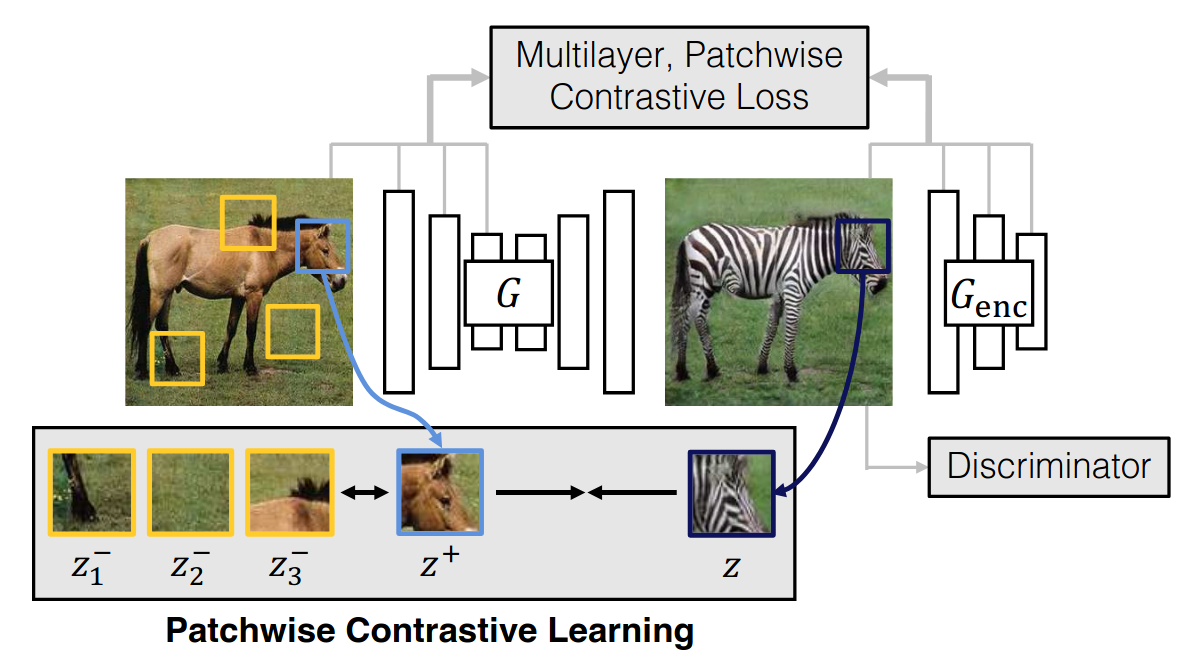

> Hình trên cho thấy luồng xử lý trong CUT:
>
> * Ảnh gốc → Generator → Ảnh giả
> * So sánh các patch để tính contrastive loss
> * Discriminator đánh giá ảnh giả để cập nhật mô hình

---

### 🔍 Cận cảnh phần so sánh các "patches":

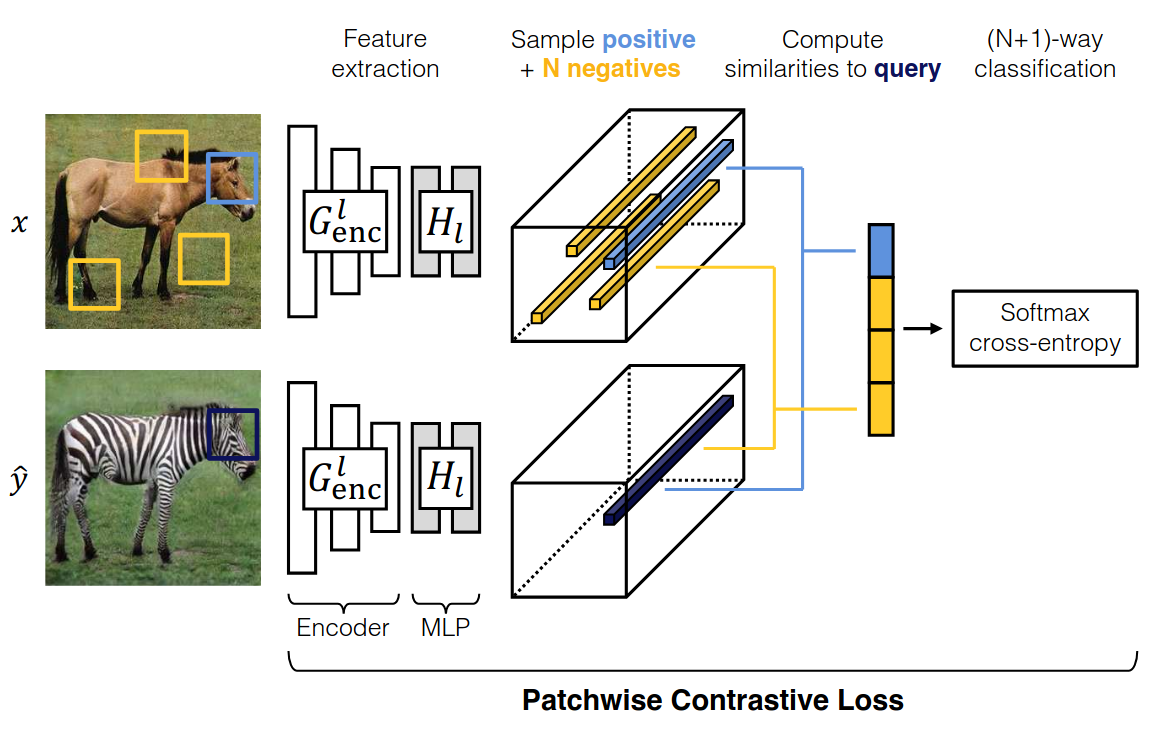

> Hình trên giải thích cách mà các **patch** từ ảnh A và ảnh G(A) được **so khớp và so sánh** trong không gian đặc trưng (feature space), giúp mô hình học cách giữ lại thông tin quan trọng từ ảnh gốc.

---

## 7. Tổng kết

| Thành phần        | Vai trò chính                                                        |
| ----------------- | -------------------------------------------------------------------- |
| Generator (G)     | Tạo ảnh mới theo phong cách miền B                                   |
| Discriminator (D) | Kiểm tra ảnh thật hay giả để huấn luyện Generator                    |
| Contrastive Loss  | Buộc các phần tương ứng giữa ảnh gốc và ảnh dịch giữ nguyên nội dung |

📌 Nhờ sự kết hợp này, **CUT vừa tạo được ảnh chất lượng cao, vừa không cần dữ liệu có cặp**, phù hợp cho nhiều bài toán thị giác máy tính thiếu dữ liệu song song.


## Huấn luyện mô hình

Đoạn code sau sẽ train mô hình CUT để xóa hiệu ứng mưa từ ảnh, code train và mô hình đã có sẵn từ github

In [ ]:
# # !bash ./datasets/download_cut_dataset.sh grumpifycat

# # 3. (Optional) Start Visdom server in background if you want to monitor
# import subprocess
# subprocess.Popen(["python", "-m", "visdom.server"], stdout=subprocess.PIPE)

# 4. Train CUT model
!python train.py --dataroot ./datasets/grumpifycat \
                 --name grumpycat_CUT \
                 --CUT_mode CUT \
                 --display_id -1  # disable visdom visualization if not needed

# 5. Test the trained model on the train set (no separate test set)
!python test.py --dataroot ./datasets/grumpifycat \
                --name grumpycat_CUT \
                --CUT_mode CUT \
                --phase train \
                --num_test 100


# Giải thích FID Score (Fréchet Inception Distance)

## 🔍 1. FID là gì?

- **FID (Fréchet Inception Distance)** là thước đo chất lượng ảnh được sinh ra từ các mô hình học máy (như GAN hay diffusion models) so sánh với ảnh thật
- FID được giới thiệu năm 2017 và trở thành tiêu chuẩn đánh giá chất lượng ảnh tổng hợp

---

## 2. Tại sao không so sánh từng ảnh?

- So sánh từng ảnh theo từng pixel (ví dụ L2 norm) không phản ánh đúng chất lượng ảnh tổng thể. Một ảnh có thể hơi khác pixel nhưng nhìn vẫn tự nhiên.
- FID đo **phân phối** của các ảnh: lấy rất nhiều ảnh thật và ảnh sinh, rồi sử dụng **feature vectors** do Inception‑v3 tạo ra (đầu ra trước khi phân loại cuối) để đếm thống kê

---

## 3. Cách tính FID?

Giả sử hai tập ảnh:

1. Tập ảnh thật → trích feature → có vector đặc trưng với mean = μ, covariance = Σ  
2. Tập ảnh sinh → mean = μ', covariance = Σ'

Ta giả định rằng hai tập ảnh này tuân theo phân phối Gaussian đa biến; FID là:

```
FID² = ||μ − μ'||² + Tr(Σ + Σ' − 2·(Σ·Σ')^(1/2))
```

- **||μ − μ'||²**: khoảng cách square giữa hai trung bình  
- **Tr(...)**: trace, tổng phương sai, thêm phần đối chiếu covariance

👉 FID = 0 → ảnh sinh giống thật hoàn hảo  
👉 FID càng cao → chất lượng và đa dạng ảnh sinh càng kém

---

## 4. FID dùng khi nào? 💡

- Dùng để:
  - So sánh các mô hình GAN hoặc diffusion khác nhau
  - Theo dõi quá trình training để xem ảnh sinh có ngày càng giống thật không
  - Lựa chọn giữa cấu hình hay kiến trúc mô hình khác nhau
  
---

## 5. Ưu – Nhược điểm

### ✅ Ưu
- Kết hợp cả chất lượng (realism) và đa dạng (diversity) trong 1 chỉ số 
- Phản ánh tốt hơn cảm quan của con người so với chỉ Inception Score (IS)

### ⚠️ Nhược
- Giả sử feature vectors là phân phối Gaussian – đôi khi không đúng.
- Công thức cần tính căn ma trận nên nếu không đúng phần implementation dễ xảy ra lỗi số
- Có thể không phù hợp cho một số loại ảnh đặc thù (ví dụ y khoa)

---

## 6. Tóm tắt đơn giản

| Khái niệm      | Giải thích ngắn gọn |
|----------------|---------------------|
| Mục đích       | So sánh tổng thể chất lượng & đa dạng giữa ảnh thật và ảnh sinh |
| Công cụ        | Dùng Inception‑v3 trích feature, tính phân phối Gaussian |
| Đầu ra         | Một số ≥ 0, càng nhỏ càng tốt |
| Ứng dụng       | Đánh giá GAN/diffusion, chọn mô hình, theo dõi training |



In [ ]:
# 6. Evaluate FID
# FID = Fréchet Inception Distance between real (trainB) and fake_B images
!python -m pytorch_fid ./datasets/grumpifycat/trainB ./results/grumpycat_CUT/train_latest/images/fake_B

## Hiển thị kết quả
phần code sau hiển thị kết quả sau khi huấn luyện mô hình

In [ ]:

# 7. Show a few generated images (optional)
import os
from IPython.display import Image, display

generated_dir = "./results/grumpycat_CUT/train_latest/images"
sample_files = [f for f in os.listdir(generated_dir) if f.endswith("fake_B.png")][:5]

for fname in sample_files:
    display(Image(filename=os.path.join(generated_dir, fname)))